<a href="https://colab.research.google.com/github/IrinaFab/Bank-MK/blob/main/BankMK_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
# Importing basic libraries
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

#import random

# Visualization libraries
import matplotlib as mpl  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

# Deep learning libraries
# import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
# from tensorflow import keras
# from tensorflow.keras import models
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.datasets import mnist
# # from plot_keras_history import plot_history

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import confusion_matrix

tf.compat.v1.disable_eager_execution() 

# Getting consistent results 
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

### Verifying TensorFlow version and Keras version

In [102]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version:", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version: 2.8.2


In [103]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [104]:
def plot_confusion_matrix(labels_true, labels_pred):
    mtx = confusion_matrix(labels_true, labels_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [105]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

In [106]:
data['education'].value_counts()

data_1 = data.copy()
data_1 = data[data_1['education'] != 'illiterate']

data_1['edu_new'] = data_1['education'].map({'basic.4y': 'pre_high', 
                                         'basic.9y': 'pre_high',
                                         'basic.6y': 'pre_high',
                                         'university.degree' : 'post_high',
                                         'professional.course':'post_high',
                                         'high.school' : 'high',
                                         'unknown' :'unknown' })

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [107]:
data_1['edu_new'].value_counts()

post_high    17411
pre_high     12513
high          9515
unknown       1731
Name: edu_new, dtype: int64

In [108]:
def map_job(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed']:
        cat = 'white_collar'
    elif row['job'] in ['housemaid', 'blue-collar', 'technician', 'services']:
        cat = 'blue_collar'
    elif row['job'] in ['student', 'retired', 'unemployed']:
        cat = 'not_working'
    else:
        cat = 'unknown'
    return cat

data_1['job_new'] = data_1.apply(map_job, axis=1)
data_1['job_new'].value_counts(dropna = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


blue_collar     21017
white_collar    16217
not_working      3606
unknown           330
Name: job_new, dtype: int64

In [109]:
def map_month(row):
    if row['month'] in ['mar', 'apr', 'may']:
        cat = 'spring'
    elif row['month'] in ['jun', 'jul', 'aug']:
        cat = 'summer'
    elif row['month'] in ['sep', 'oct', 'nov']:
        cat = 'fall'
    else:
        cat = 'winter'
    return cat

data_1['season'] = data_1.apply(map_month, axis=1)
data_1['season'].value_counts(dropna = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


summer    18660
spring    16942
fall       5386
winter      182
Name: season, dtype: int64

In [110]:
data_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new',
       'season'],
      dtype='object')

In [111]:
#This transformed dataframe is based on group discussion on 7/23
# - keep all numerical features as they are
# - consolidate categorical features (education, job, season) and drop originial ones

df_tran_1 = data_1[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [112]:
df_tran_1 = df_tran_1.drop(['duration'], axis=1)
df_tran_1.columns

Index(['age', 'marital', 'default', 'housing', 'loan', 'contact',
       'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'edu_new', 'job_new', 'season'],
      dtype='object')

In [113]:
df_tran_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41170 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41170 non-null  int64  
 1   marital         41170 non-null  object 
 2   default         41170 non-null  object 
 3   housing         41170 non-null  object 
 4   loan            41170 non-null  object 
 5   contact         41170 non-null  object 
 6   day_of_week     41170 non-null  object 
 7   campaign        41170 non-null  int64  
 8   pdays           41170 non-null  int64  
 9   previous        41170 non-null  int64  
 10  poutcome        41170 non-null  object 
 11  emp.var.rate    41170 non-null  float64
 12  cons.price.idx  41170 non-null  float64
 13  cons.conf.idx   41170 non-null  float64
 14  euribor3m       41170 non-null  float64
 15  nr.employed     41170 non-null  float64
 16  y               41170 non-null  object 
 17  edu_new         41170 non-null 

In [114]:
d1=df_tran_1.copy()
d2=d1[d1.y=='yes']
d1=pd.concat([d1, d2])
d1=pd.concat([d1, d2])
d1=pd.concat([d1, d2])
d1=pd.concat([d1, d2])
d1=pd.concat([d1, d2])
d1=pd.concat([d1, d2])
d1=pd.concat([d1, d2])
df_tran_1=d1

In [115]:
df_tran_1['y'].value_counts(normalize='True')

yes    0.503762
no     0.496238
Name: y, dtype: float64

In [116]:
# TARGET = 'y'

In [117]:
#replacing no and yes by 0 and 1 respectively as our target values!
df_tran_1['y'] = df_tran_1['y'].replace(['no','yes'],[0,1])
df_tran_1['y'].unique()

array([0, 1])

In [118]:
# from sklearn.preprocessing import LabelEncoder

# # encode strings to integer
# df_tran_1['y'] = LabelEncoder().fit_transform(df_tran_1['y'])
# df_tran_1['y']

In [119]:
# Using OneHotEncoding pandas.get_dummies

# listing down the features that has categorical data
categorial_features = ['edu_new','job_new', 'marital', 'season', 'contact', 'poutcome', 'day_of_week', 'housing', 'default', 'loan']
# categorial_features = ['job', 'marital', 'poutcome']
for item in categorial_features:
    # assigning the encoded data into a new DataFrame object
    df = pd.get_dummies(df_tran_1[item], prefix=item)
    df_tran_1 = df_tran_1.drop(item, axis=1)
    for categorial_feature in df.columns:
        #Set the new column in data to have corresponding df values
        df_tran_1[categorial_feature] = df[categorial_feature]

In [120]:
df_tran_1.head(10).T

,0,1,2,3,4,5,6,7,8,9
age,56.000,57.000,37.000,40.000,56.000,45.000,59.000,41.000,24.000,25.000
campaign,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
pdays,999.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000
previous,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
emp.var.rate,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100
cons.price.idx,93.994,93.994,93.994,93.994,93.994,93.994,93.994,93.994,93.994,93.994
cons.conf.idx,-36.400,-36.400,-36.400,-36.400,-36.400,-36.400,-36.400,-36.400,-36.400,-36.400
euribor3m,4.857,4.857,4.857,4.857,4.857,4.857,4.857,4.857,4.857,4.857
nr.employed,5191.000,5191.000,5191.000,5191.000,5191.000,5191.000,5191.000,5191.000,5191.000,5191.000
y,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [121]:
df_tran_1.head().T

,0,1,2,3,4
age,56.000,57.000,37.000,40.000,56.000
campaign,1.000,1.000,1.000,1.000,1.000
pdays,999.000,999.000,999.000,999.000,999.000
previous,0.000,0.000,0.000,0.000,0.000
emp.var.rate,1.100,1.100,1.100,1.100,1.100
cons.price.idx,93.994,93.994,93.994,93.994,93.994
cons.conf.idx,-36.400,-36.400,-36.400,-36.400,-36.400
euribor3m,4.857,4.857,4.857,4.857,4.857
nr.employed,5191.000,5191.000,5191.000,5191.000,5191.000
y,0.000,0.000,0.000,0.000,0.000


In [122]:
# checking the final info about the dataset 
df_tran_1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,73622.0,40.409769,12.049960,17.000,31.000,38.000,48.000,98.000
campaign,73622.0,2.340292,2.362595,1.000,1.000,2.000,3.000,56.000
pdays,73622.0,887.367146,313.687868,0.000,999.000,999.000,999.000,999.000
previous,73622.0,0.313996,0.699010,0.000,0.000,0.000,0.000,7.000
emp.var.rate,73622.0,-0.497588,1.722844,-3.400,-1.800,-0.100,1.400,1.400
cons.price.idx,73622.0,93.478450,0.633277,92.201,92.893,93.444,93.994,94.767
cons.conf.idx,73622.0,-40.189222,5.358150,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,73622.0,2.961064,1.890510,0.634,1.244,4.021,4.959,5.045
nr.employed,73622.0,5135.326661,87.043679,4963.600,5076.200,5191.000,5228.100,5228.100
y,73622.0,0.503762,0.499989,0.000,0.000,1.000,1.000,1.000


In [ ]:
y = df_tran_1['y']
X = df_tran_1.values[:, :-1] 

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)

In [130]:
print('Shape of input TRAINING data set = ', PCA_X_train.shape)
print('Shape of output TRAINING data set = ', y_train.shape, '\n')
print('Shape of input TEST data set = ', PCA_X_test.shape)
print('Shape of output TEST data set = ', y_test.shape)


Shape of input TRAINING data set =  (58897, 27)
Shape of output TRAINING data set =  (58897,) 

Shape of input TEST data set =  (14725, 27)
Shape of output TEST data set =  (14725,)


In [124]:
scaler = StandardScaler()  
scaler.fit(X)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [125]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [127]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
PCA_X_train = pca.transform(X_train)
PCA_X_test = pca.transform(X_test)

X_train

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.697913,-0.567301,0.355875,-0.449204,1.101435,0.694092,-0.468594,1.058947,1.065832,-1.007553,...,-0.500522,-0.500925,-0.896104,-0.155538,0.939790,0.434394,-0.434327,-0.006384,0.457837,-0.155538
1,1.044843,0.279232,0.355875,-0.449204,-1.394455,-0.813947,-0.113991,-0.898739,-0.679280,0.992503,...,1.997914,-0.500925,-0.896104,-0.155538,0.939790,0.434394,-0.434327,-0.006384,0.457837,-0.155538
2,-0.614925,0.279232,0.355875,-0.449204,1.101435,-0.054400,0.763183,1.060534,1.065832,0.992503,...,1.997914,-0.500925,-0.896104,-0.155538,0.939790,0.434394,-0.434327,-0.006384,0.457837,-0.155538
3,1.625762,-0.567301,0.355875,-0.449204,0.927303,0.814104,0.707193,1.001819,0.639607,-1.007553,...,-0.500522,-0.500925,-0.896104,-0.155538,0.939790,0.434394,-0.434327,-0.006384,0.457837,-0.155538
4,0.878866,0.702498,0.355875,-0.449204,-1.394455,-2.017220,1.640357,-1.117200,-0.679280,0.992503,...,-0.500522,-0.500925,-0.896104,-0.155538,0.939790,0.434394,-0.434327,-0.006384,-2.184183,-0.155538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58892,-1.029867,-0.144034,0.355875,-0.449204,1.101435,1.557859,-0.300624,1.007638,1.065832,0.992503,...,-0.500522,-0.500925,1.115942,-0.155538,-1.064068,0.434394,-0.434327,-0.006384,0.457837,-0.155538
58893,-0.946878,-0.567301,-2.809714,0.981400,-0.697928,0.866214,0.352591,-1.088107,-1.651213,0.992503,...,-0.500522,-0.500925,1.115942,-0.155538,-1.064068,0.434394,-0.434327,-0.006384,0.457837,-0.155538
58894,-1.029867,0.279232,0.355875,-0.449204,-1.394455,-0.813947,-0.113991,-0.895565,-0.679280,0.992503,...,-0.500522,-0.500925,-0.896104,-0.155538,0.939790,0.434394,-0.434327,-0.006384,0.457837,-0.155538
58895,-0.780902,0.279232,0.355875,-0.449204,1.101435,-0.054400,0.763183,1.059476,1.065832,-1.007553,...,-0.500522,-0.500925,1.115942,-0.155538,-1.064068,0.434394,-0.434327,-0.006384,0.457837,-0.155538


In [128]:
# define and train an MLPClassifier named mlp on the given data
mlp = MLPClassifier(hidden_layer_sizes=(50,200,50), max_iter=300, activation='relu', solver='adam', random_state=1)
mlp.fit(PCA_X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50, 200, 50), max_iter=300, random_state=1)

In [131]:
print('Accuracy')
print(mlp.score(PCA_X_test, y_test))


Accuracy
0.9997962648556876


Accuracy
0.9997962648556876


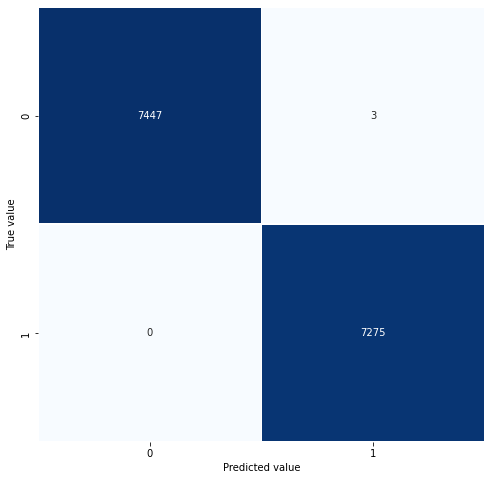

In [129]:
predict = mlp.predict(PCA_X_test)
confusion_matrix = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8,8))
ax =  sns.heatmap(confusion_matrix, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()